# Linear Regression

## The Normal Equation
正規方程式を解く。

$$
\hat{\theta}=(X^TX)^{-1}X^Ty
$$

$\hat{\theta}$はコスト関数を最小化する$\theta$、$y$は目標値。


In [3]:
import numpy as np

In [5]:
# y=4+3X+noise
X=2*np.random.rand(100,1)
y=4+3*X+np.random.randn(100,1)

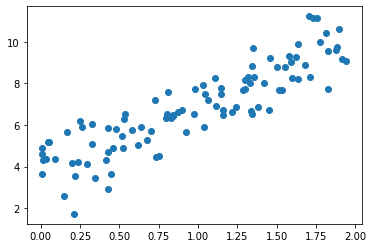

In [6]:
import matplotlib.pyplot as plt

plt.scatter(X,y)

行列演算で$\hat{\theta}$を直接解く

In [4]:
X_b=np.c_[np.ones((100,1)), X ]
theta_best=np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.1299594 ],
       [2.83788959]])

理想的には$\theta_0=4$、$\theta_1=3$だがノイズを含んでいるので十分な結果。

In [6]:
X_new=np.array([[0],[2]])
X_new_b=np.c_[np.ones((2,1)),X_new]
y_predict=X_new_b.dot(theta_best)
y_predict


array([[4.1299594 ],
       [9.80573858]])

(0.0, 2.0, 0.0, 15.0)

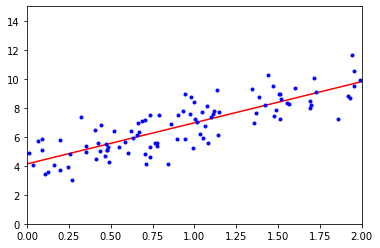

In [7]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X,y,'b.')
plt.axis([0,2,0,15])

同じことをsklearnで

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.1299594]), array([[2.83788959]]))

In [9]:
lin_reg.predict(X_new)

array([[4.1299594 ],
       [9.80573858]])

LinearRegressionは`scipy.linalg.lstsq()`(least squares:最小二乗法)に基づき、以下の計算を行なっている。

$$
\hat{\theta}=X^+y
$$

$X^+$はXの擬似逆行列

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.1299594 ],
       [2.83788959]])

擬似逆行列は次のように求めることもできる。

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.1299594 ],
       [2.83788959]])

擬似逆行列は特異値分解（SVD）で計算する。

正規方程式やSVDは特徴量が多いデータセットには不向きで、そういった場合は次の勾配降下法を用いる。

# Gradient Descent

## Batch Gradient Descent

実装例

In [13]:
eta=0.1
n_iterations=1000
m=100

theta=np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients=2/m*X_b.T.dot(X_b.dot(theta) -y)
    theta=theta-eta*gradients

In [14]:
theta

array([[4.1299594 ],
       [2.83788959]])

## Stochastic Gradient Descent

実装例

In [15]:
n_epochs=50
t0, t1=5,50

def learning_schedule(t):
    return t0/(t + t1)

theta= np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index=np.random.randint(m)
        xi = X_b[random_index:random_index +1]
        yi=y[random_index:random_index+1]
        gradients=2*xi.T.dot(xi.dot(theta) -yi)
        eta=learning_schedule(epoch*m +i)
        theta=theta-eta*gradients

In [16]:
theta

array([[4.14106335],
       [2.91707638]])

Batch GDでは1000回のイテレーションが必要だったがSGDは50回で済んだ。

[SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html): Stochastic GDを使った線形回帰

In [17]:
from sklearn.linear_model import SGDRegressor
sgd_reg=SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [18]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.11762533]), array([2.85349813]))

# Polynomial Regression

In [20]:
m=100
X=6*np.random.rand(m,1) -3
y=0.5*X**2 +X+2+np.random.randn(m,1)

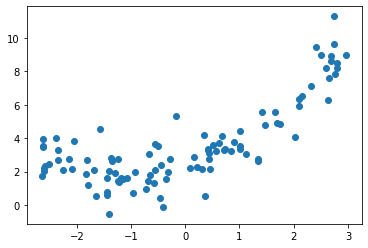

In [21]:
plt.scatter(X,y)

[PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures): 多項式の生成

In [70]:
from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2, include_bias=False)
X_poly=poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.41845724]
[2.41845724 5.84893542]


In [71]:
lin_reg=LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.27603349]), array([[0.98257292, 0.4786341 ]]))

In [72]:
X_new = np.arange(-3,3,0.1).reshape(-1,1)
X_poly_new= poly_features.transform(X_new)
y_new = lin_reg.predict(X_poly_new)

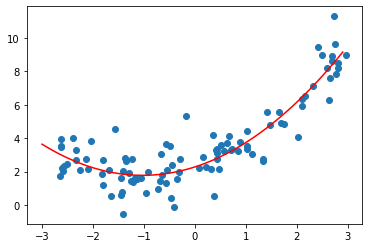

In [73]:
plt.scatter(X,y)
plt.plot(X_new, y_new, c='r')

[PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures)は多変数にも対応し与えられた次数内で全ての組み合わせを作る。

# Learning Curves

訓練データサイズに対する訓練・検証データの性能（誤差）をプロット。

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
    train_errors, val_errors=[],[]
    # データ数を増やしながらフィッティングを繰り返す
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict= model.predict(X_train[:m])
        y_val_predict=model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.legend()

線形回帰モデルに対する学習曲線

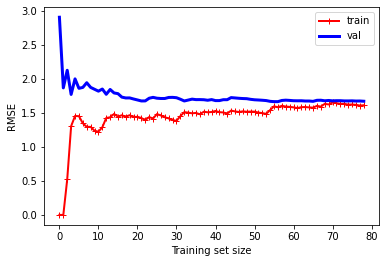

In [69]:
lin_reg=LinearRegression()
plot_learning_curves(lin_reg, X, y)

データはノイズを含み、かつ線形ではないため線形回帰ではフィッティングができずエラーが大きいまま横ばい（plateau）に-->underfitting

trainとvalは同じエラー値に収束している。

こういった場合データを増やしても改善は見込めず、モデルの見直しが必要。


１０次の多項式モデルに対する学習曲線

(0.0, 3.0)

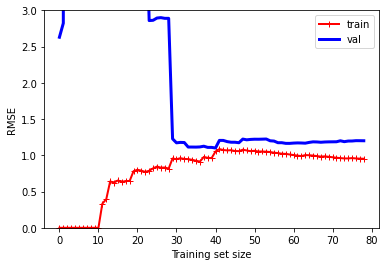

In [66]:
from sklearn.pipeline import Pipeline

polynomial_regression=Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)
plt.ylim(0,3)

- 訓練データのエラーが線形回帰モデルのものより小さい
- trainとvalの間にギャップがある-->overfitting

訓練データ数を増やすことでギャップは小さくなるはず

# Regularized Linear Models

オーバーフィッティングを減らすための正規化。

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

[ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)

## Ridge Regression
l２ノルムともいう。

$$
J(\theta)=MSE(\theta)+\frac{\alpha}{2}\sum_{i=1}^n\theta_i^2
$$

バイアス項$\theta_0$は含まれない

In [46]:
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.25573608]])

In [49]:
sgd_reg=SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.23082073])

## Lasso Regression

l1ノルムともいう。

$$
J(\theta)=MSE(\theta)+\alpha\sum_{i=1}^n|\theta_i|
$$

In [51]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=0.1)
# SGDRegressor(penalty="l1")
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([5.20653037])

## Elastic Net

$$
J(\theta)=MSE(\theta)+r\alpha\sum_{i=1}^n|\theta_i|+\frac{1-r}{2}\alpha\sum_{i=1}^n\theta_i^2
$$

r:mix ratio, ElasticNet()の`l1_ratio`に相当

In [52]:
from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([5.20497301])

## Early Stopping

基本的な実装例

`warm_start=True`とするとfitメソッドが呼ばれたときつづきから訓練が行われる。

In [58]:
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
    ('std_scaler', StandardScaler()),
])
X_train_poly_scaled=poly_scaler.fit_transform(X_train)
X_val_poly_scaled=poly_scaler.transform(X_val)

sgd_reg=SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                     penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error= float("inf")
best_epoch=None
best_model=None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_predict=sgd_reg.predict(X_val_poly_scaled)
    val_error=mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error=val_error
        best_epoch=epoch
        best_model=clone(sgd_reg)


In [59]:
best_epoch

92

In [60]:
best_model

SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             tol=-inf, warm_start=True)

# Logistic Regression

## Estimating Probabilities

Logistic function

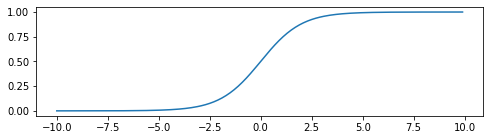

In [76]:
t=np.arange(-10,10,0.1)
sigma=1/(1+np.exp(-t))

plt.figure(figsize=(8,2))
plt.plot(t, sigma)

## Decision Boundaries

In [1]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

petal widthだけ使ってIris-virginicaかそうでないかを予想。

In [8]:
X=iris["data"][:,3:]
y=(iris["target"] ==2).astype(np.int32)

[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression): ロジスティック回帰。

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

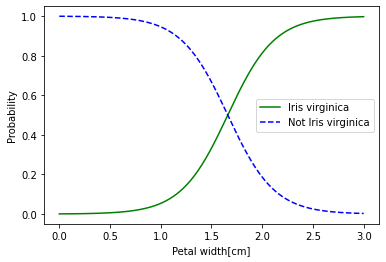

In [10]:
X_new=np.linspace(0, 3, 1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label="Iris virginica")
plt.plot(X_new, y_proba[:,0], 'b--', label="Not Iris virginica")
plt.xlabel('Petal width[cm]')
plt.ylabel('Probability')
plt.legend()


Petal width>2なら分類器は強い確信を持ってTrueと言え、1以下ならFalseと言える。その間は不確かとなるが分類器としてはもっともらしい解（最大確率）を出力する。  
その決定境界は1.6cm付近にある。それより大きければ１、小さければ0と予測する。


In [11]:
log_reg.predict([[1.7,],[1.5]])

array([1, 0], dtype=int32)

## Softmax Regression

多クラス分類。LogisticRegressionの引数で`multi_class="multinomial"`とするとSoftmaxが有効になる。また`solver=lbfgs`と対応したソルバの指定も必要。

petal lengthとpetal widthだけを使ってクラス分類をする。

In [12]:
X=iris['data'][:,(2,3)]
y=iris['target']

softmax_reg=LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

length=5, width=2として予測を得るとIris virginicaと答える(94.3%の確率で)。

In [13]:
softmax_reg.predict([[5,2]])

array([2])

In [14]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])